In [36]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.metrics import dtw, soft_dtw
from tslearn.utils import to_time_series_dataset
from sklearn.utils.validation import _check_large_sparse
from tslearn.clustering import TimeSeriesKMeans
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import pairwise_distances_argmin_min, jaccard_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [37]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [72]:
X_df = pd.read_csv('../new_data/NA/na_dataset.csv', index_col=None)
Y_df = pd.read_csv('../new_data/NA/na_emoji_labels.csv', usecols=['filename', 'emoji'], index_col='filename')
Y_df["emoji"] = Y_df["emoji"].apply(eval)
label_cols = to_1D(Y_df["emoji"]).unique() 
# label_cols.append('smilingimp')
labels_expanded = boolean_df(Y_df['emoji'], label_cols )
labels_expanded

,neutral,smirk,furious,weary,expressionless,unamused,rollingeyes,none,skeptical,angry,nauseated,vomiting,triumph,hatred
filename,,,,,,,,,,,,,,
na/vid_1.mp4,1,1,0,0,0,0,0,0,0,0,0,0,0,0
na/vid_100.mp4,0,0,1,0,0,0,0,0,0,0,0,0,0,0
na/vid_101.mp4,0,0,1,0,0,0,0,0,0,0,0,0,0,0
na/vid_102.mp4,0,0,0,1,0,0,0,0,0,0,0,0,0,0
na/vid_104.mp4,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
na/vid_90.mp4,0,0,0,0,0,0,0,0,0,1,0,0,0,0
na/vid_92.mp4,0,0,0,0,0,0,0,0,0,0,0,0,0,1
na/vid_93.mp4,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [73]:
labels_expanded.loc['na/vid_5.mp4']

neutral           1
smirk             0
furious           0
weary             0
expressionless    0
unamused          0
rollingeyes       0
none              0
skeptical         0
angry             0
nauseated         0
vomiting          0
triumph           0
hatred            0
Name: na/vid_5.mp4, dtype: int64

In [74]:
for l in label_cols:
    X_df[label_cols]  = np.NaN
    

In [75]:
X_df.head()

,filename,culture,frame,face_id,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,...,expressionless,unamused,rollingeyes,none,skeptical,angry,nauseated,vomiting,triumph,hatred
0,na/vid_1.mp4,north american,1,0,0.000,0.98,1,1.45,1.86,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,na/vid_1.mp4,north american,2,0,0.017,0.98,1,1.50,1.98,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,na/vid_1.mp4,north american,3,0,0.033,0.98,1,1.57,1.98,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,na/vid_1.mp4,north american,4,0,0.050,0.98,1,1.56,1.99,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,na/vid_1.mp4,north american,5,0,0.067,0.98,1,1.40,1.94,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
label_cols.tolist()

['neutral',
 'smirk',
 'furious',
 'weary',
 'expressionless',
 'unamused',
 'rollingeyes',
 'none',
 'skeptical',
 'angry',
 'nauseated',
 'vomiting',
 'triumph',
 'hatred']

In [76]:
print(labels_expanded.at['na/vid_5.mp4', 'hatred'])

0


In [77]:
for index, row in X_df.iterrows():
    # print(index, row)
    filename = X_df.iloc[index]['filename']
    # print(filename)
    for l in label_cols.tolist():
        try:
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
            X_df.at[index, l] = labels_expanded.at[filename, l]
        except Exception:
            # print("here")
            print('expanded labels: filename: {}, label: {}, {}'.format(filename, l, labels_expanded.at[filename, l]))
            print(X_df.at[index, l])
        

In [78]:
X_df.head()

,filename,culture,frame,face_id,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,...,expressionless,unamused,rollingeyes,none,skeptical,angry,nauseated,vomiting,triumph,hatred
0,na/vid_1.mp4,north american,1,0,0.000,0.98,1,1.45,1.86,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,na/vid_1.mp4,north american,2,0,0.017,0.98,1,1.50,1.98,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,na/vid_1.mp4,north american,3,0,0.033,0.98,1,1.57,1.98,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,na/vid_1.mp4,north american,4,0,0.050,0.98,1,1.56,1.99,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,na/vid_1.mp4,north american,5,0,0.067,0.98,1,1.40,1.94,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Min-Max Scaling

In [ ]:
## Ablation cols
ablation_cols = ['AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r', 'AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r','AU25_r','AU26_r','AU45_r']

In [ ]:
X_df = X_df.drop(columns=ablation_cols)
X_df

In [79]:
cols_to_scale = list (
    set(X_df.columns.to_list()) - set(['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'])- set(label_cols)
    )
scaler = MinMaxScaler()
X_df[cols_to_scale] = scaler.fit_transform(X_df[cols_to_scale])

In [80]:
X_df.tail()

,filename,culture,frame,face_id,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,...,expressionless,unamused,rollingeyes,none,skeptical,angry,nauseated,vomiting,triumph,hatred
6871,na/vid_97.mp4,north american,92,0,3.792,0.88,1,0.176000,0.0,0.778098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6872,na/vid_97.mp4,north american,93,0,3.833,0.88,1,0.000000,0.0,0.789625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6873,na/vid_97.mp4,north american,94,0,3.875,0.88,1,0.021333,0.0,0.821326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6874,na/vid_97.mp4,north american,95,0,3.917,0.88,1,0.000000,0.0,0.853026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6875,na/vid_97.mp4,north american,96,0,3.958,0.88,1,0.000000,0.0,0.884726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Splitting into train and test

In [88]:
metadata_cols = ['frame', 'face_id', 'culture', 'filename', 'timestamp']
print(X_df.head())
videos = X_df['filename'].unique()
# test_videos = pd.Series(videos).sample(frac=0.35)
test_videos = ['na/vid_6.mp4', 'na/vid_19.mp4', 'na/vid_43.mp4', 'na/vid_25.mp4', 'na/vid_23.mp4', 'na/vid_10_1.mp4', 'na/vid_72.mp4', 'na/vid_34.mp4', 'na/vid_90.mp4', 'na/vid_92.mp4', 'na/vid_39.mp4', 'na/vid_30.mp4', 'na/vid_3.mp4', 'na/vid_33.mp4', 'na/vid_4.mp4', 'na/vid_31.mp4', 'na/vid_53.mp4', 'na/vid_52.mp4', 'na/vid_55.mp4', 'na/vid_59.mp4', 'na/vid_22.mp4', 'na/vid_11.mp4', 'na/vid_79.mp4', 'na/vid_54.mp4', 'na/vid_87.mp4', 'na/vid_63.mp4', 'na/vid_12.mp4', 'na/vid_10_2.mp4', 'na/vid_97.mp4', 'na/vid_70.mp4', 'na/vid_42.mp4', 'na/vid_49.mp4', 'na/vid_77.mp4']
# test_videos = ['persian/vid_52.mp4', 'persian/vid_40.mp4', 'persian/vid_66.mp4', 'persian/vid_18.mp4', 'persian/vid_96.mp4', 'persian/vid_65.mp4', 'persian/vid_51.mp4', 'persian/vid_85.mp4', 'persian/vid_87.mp4', 'persian/vid_70.mp4', 'persian/vid_76.mp4', 'persian/vid_27.mp4', 'persian/vid_88.mp4', 'persian/vid_21.mp4', 'persian/vid_4.mp4', 'persian/vid_61.mp4', 'persian/vid_12.mp4', 'persian/vid_46.mp4', 'persian/vid_81.mp4', 'persian/vid_93.mp4', 'persian/vid_56.mp4', 'persian/vid_55.mp4', 'persian/vid_68.mp4', 'persian/vid_38.mp4', 'persian/vid_62.mp4', 'persian/vid_14.mp4', 'persian/vid_8.mp4', 'persian/vid_83.mp4', 'persian/vid_45.mp4', 'persian/vid_91.mp4', 'persian/vid_22.mp4', 'persian/vid_36.mp4', 'persian/vid_7.mp4']
train_videos = np.array(list(set(videos) - set(test_videos)))
test_df = X_df[X_df['filename'].isin(test_videos)]
metadata_test = test_df[metadata_cols]
y_test = test_df[label_cols].values
X_test = test_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values

       filename         culture  frame  face_id  timestamp  confidence  \
0  na/vid_1.mp4  north american      1        0      0.000        0.98   
1  na/vid_1.mp4  north american      2        0      0.017        0.98   
2  na/vid_1.mp4  north american      3        0      0.033        0.98   
3  na/vid_1.mp4  north american      4        0      0.050        0.98   
4  na/vid_1.mp4  north american      5        0      0.067        0.98   

   success    AU01_r  AU02_r  AU04_r  ...  expressionless  unamused  \
0        1  0.386667   0.372     0.0  ...             0.0       0.0   
1        1  0.400000   0.396     0.0  ...             0.0       0.0   
2        1  0.418667   0.396     0.0  ...             0.0       0.0   
3        1  0.416000   0.398     0.0  ...             0.0       0.0   
4        1  0.373333   0.388     0.0  ...             0.0       0.0   

   rollingeyes  none  skeptical  angry  nauseated  vomiting  triumph  hatred  
0          0.0   0.0        0.0    0.0        0.0

In [82]:
print(test_videos.to_list())

['na/vid_6.mp4', 'na/vid_74.mp4', 'na/vid_43.mp4', 'na/vid_25.mp4', 'na/vid_23.mp4', 'na/vid_10_1.mp4', 'na/vid_72.mp4', 'na/vid_34.mp4', 'na/vid_90.mp4', 'na/vid_92.mp4', 'na/vid_39.mp4', 'na/vid_30.mp4', 'na/vid_3.mp4', 'na/vid_33.mp4', 'na/vid_4.mp4', 'na/vid_31.mp4', 'na/vid_53.mp4', 'na/vid_52.mp4', 'na/vid_55.mp4', 'na/vid_59.mp4', 'na/vid_22.mp4', 'na/vid_11.mp4', 'na/vid_79.mp4', 'na/vid_54.mp4', 'na/vid_87.mp4', 'na/vid_63.mp4', 'na/vid_12.mp4', 'na/vid_10_2.mp4', 'na/vid_97.mp4', 'na/vid_70.mp4', 'na/vid_42.mp4', 'na/vid_49.mp4', 'na/vid_77.mp4']


In [ ]:
metadata_test.iloc[800:805]

## Cross-validation

In [98]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []

col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    # print(videos[train])
    # print(videos[test])
    print('%d-th split: train: %d, test: %d' % (i+1, len(train_videos[train]), len(train_videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    print(train_videos[train])
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    base_knn =  KNeighborsClassifier(n_neighbors=5,)
    base_lr = LogisticRegression()
    base_rf = RandomForestClassifier()

    ovr = OneVsRestClassifier(base_rf)
    ovr.fit(X_train, y_train)
    valid_pred_ovr = ovr.predict(X_valid)
    ovr_jaccard_score = jaccard_score(y_valid, valid_pred_ovr, average='samples')
    ovr_ham_loss = metrics.hamming_loss(y_valid, valid_pred_ovr)
    print("One-vs-Rest validation Jaccard score:" , ovr_jaccard_score)
    print("One-vs-Rest validation Hamming loss: " , ovr_ham_loss)

    Y_pred_ovr = ovr.predict(X_test)
    a = jaccard_score(y_test, Y_pred_ovr, average='samples')
    b = metrics.hamming_loss(y_test, Y_pred_ovr)
    # print(Y_pred_ovr[800:805,:])
    # print(y_test[800:805,:])

    print("One-vs-Rest test Jaccard score: ", a)
    print("One-vs-Rest test Hamming loss: " , b)

    chains = [ClassifierChain(base_rf, order='random', random_state=i)
            for i in range(10)]
    for j, model in enumerate(chains):
        model.fit(X_train, y_train)
        valid_pred = model.predict(X_valid)
        val_score =jaccard_score(y_valid, valid_pred, average='samples')
        
        
    # predict on validation data
    valid_pred_chains = np.array([chain.predict(X_valid) for chain in
                            chains])
    chain_jaccard_scores = [jaccard_score(y_valid, valid_pred_chain >= .5,
                                    average='samples')
                    for valid_pred_chain in valid_pred_chains]
    
    print("CC Validation Jaccard Score:\n ", chain_jaccard_scores)

    chain_hamming_loss =[metrics.hamming_loss(y_valid, valid_pred_chain >= .5)
                for valid_pred_chain in valid_pred_chains]
    print("CC Validation Hamming Loss:\n ", chain_hamming_loss)

    # test on test data
    Y_pred_chains = np.array([chain.predict(X_test) for chain in
                            chains])
    chain_jaccard_scores = [jaccard_score(y_test, Y_pred_chain >= .5,
                                    average='samples')
                    for Y_pred_chain in Y_pred_chains]
    frames_mean_jac_test.append(np.mean(chain_jaccard_scores))
    print("CC Test Jaccard Score: \n ", chain_jaccard_scores)

    chain_hamming_loss =[metrics.hamming_loss(y_test, Y_pred_chain) 
                for Y_pred_chain in Y_pred_chains]
    frames_mean_hm_test.append(np.mean(chain_hamming_loss))
    print("CC Test Hamming Loss:\n ", chain_hamming_loss)
    ## voting predicted labels
    test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    test_result_df.update(metadata_test)
    temp_df = pd.DataFrame(data=Y_pred_chains[-1], columns=label_cols)
    test_result_df = pd.concat([test_result_df, temp_df], axis=1)
    video_groups = test_result_df.groupby('filename')[label_cols].apply(lambda x :              x.astype(int).sum())
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0
        # print("          &&&&&&&&&&&&&&&&            ")
    print(np.array(ground_truth_video_labels,  dtype=int).shape)
    print(video_groups.values.shape)

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)

1-th split: train: 48, test: 13
['na/vid_101.mp4' 'na/vid_20.mp4' 'na/vid_86.mp4' 'na/vid_73.mp4'
 'na/vid_95.mp4' 'na/vid_45.mp4' 'na/vid_80.mp4' 'na/vid_36.mp4'
 'na/vid_18.mp4' 'na/vid_26.mp4' 'na/vid_13.mp4' 'na/vid_21.mp4'
 'na/vid_37.mp4' 'na/vid_50.mp4' 'na/vid_81.mp4' 'na/vid_58.mp4'
 'na/vid_10_3.mp4' 'na/vid_76.mp4' 'na/vid_69.mp4' 'na/vid_93.mp4'
 'na/vid_29.mp4' 'na/vid_5.mp4' 'na/vid_61.mp4' 'na/vid_100.mp4'
 'na/vid_78.mp4' 'na/vid_46.mp4' 'na/vid_84.mp4' 'na/vid_15.mp4'
 'na/vid_75.mp4' 'na/vid_104.mp4' 'na/vid_2.mp4' 'na/vid_88.mp4'
 'na/vid_32.mp4' 'na/vid_67.mp4' 'na/vid_89.mp4' 'na/vid_57.mp4'
 'na/vid_60.mp4' 'na/vid_24.mp4' 'na/vid_51.mp4' 'na/vid_62.mp4'
 'na/vid_17.mp4' 'na/vid_9.mp4' 'na/vid_68.mp4' 'na/vid_35.mp4'
 'na/vid_66.mp4' 'na/vid_14.mp4' 'na/vid_47.mp4' 'na/vid_1.mp4']
Training+validation data size:  3524
Training data size:  3524
Validation data size:  1100
One-vs-Rest validation Jaccard score: 0.9596103896103895
One-vs-Rest validation Hamming loss:  

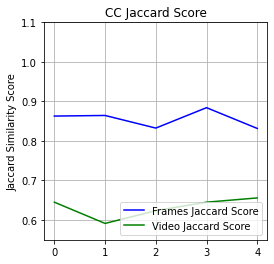

In [99]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.55, 1.1])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='lower right')
plt.show()

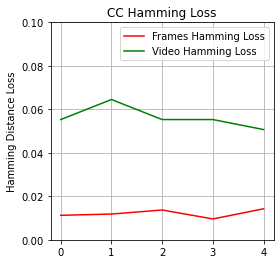

In [100]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, .1])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

In [20]:
print(test_videos.to_list())

['persian/vid_52.mp4', 'persian/vid_40.mp4', 'persian/vid_66.mp4', 'persian/vid_86.mp4', 'persian/vid_96.mp4', 'persian/vid_65.mp4', 'persian/vid_51.mp4', 'persian/vid_85.mp4', 'persian/vid_87.mp4', 'persian/vid_70.mp4', 'persian/vid_76.mp4', 'persian/vid_27.mp4', 'persian/vid_88.mp4', 'persian/vid_21.mp4', 'persian/vid_4.mp4', 'persian/vid_61.mp4', 'persian/vid_12.mp4', 'persian/vid_46.mp4', 'persian/vid_81.mp4', 'persian/vid_93.mp4', 'persian/vid_56.mp4', 'persian/vid_55.mp4', 'persian/vid_68.mp4', 'persian/vid_38.mp4', 'persian/vid_62.mp4', 'persian/vid_14.mp4', 'persian/vid_8.mp4', 'persian/vid_83.mp4', 'persian/vid_45.mp4', 'persian/vid_91.mp4', 'persian/vid_22.mp4', 'persian/vid_36.mp4', 'persian/vid_7.mp4']


In [93]:
from skmultilearn.adapt import MLkNN
import sklearn.metrics as metrics

## MLTSVM is not compatible with later versions of numpy

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    print('%d-th split: train: %d, validation: %d' % (i+1, len(videos[train]), len(videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    classifier = MLkNN(k=5)
    # classifier = MLTSVM(c_k = 2**-1)
    prediction = classifier.fit(X_train, y_train).predict(X_valid)

    # Predicting on validation set
    print("Validation Hamming Loss:\n ", metrics.hamming_loss(y_valid, prediction))

    # Predicting on test set
    y_test_pred = classifier.predict(X_test)
    hm_loss = metrics.hamming_loss(y_test, y_test_pred)
    frames_mean_hm_test.append(hm_loss)
    print("Test Hamming Loss:\n ", hm_loss)
    jac_score = jaccard_score(y_test, y_test_pred,  average='samples')
    frames_mean_jac_test.append(jac_score)
    print("Test Jaccard Score:\n ", jac_score)

    # building test dataframe to vote labels
    test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    test_result_df.update(metadata_test)
    # print("^^^^^^^^", y_test_pred.toarray().shape)
    temp_df = pd.DataFrame(data=y_test_pred.toarray(), columns=label_cols)
    test_result_df = pd.concat([test_result_df, temp_df], axis=1)
    
    # print(test_result_df.head())
    video_groups = test_result_df.groupby('filename')[label_cols].apply(lambda x : x.astype(int).sum())
    # for name, group in video_groups:
    #     print(name)
    #     print(group)
    #     print("\n") 
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        print(len(ground_truth_video_labels))
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)
        

1-th split: train: 48, validation: 13
Training+validation data size:  3524
Training data size:  3524
Validation data size:  1100
Validation Hamming Loss:
  0.0651948051948052
Test Hamming Loss:
  0.015478304998731287
Test Jaccard Score:
  0.8936500888099467
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
2-th split: train: 49, validation: 12
Training+validation data size:  3726
Training data size:  3726
Validation data size:  898
Validation Hamming Loss:
  0.026089723194400255
Test Hamming Loss:
  0.016810454199441768
Test Jaccard Score:
  0.8841030195381883
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
3-th split: train: 49, validation: 12
Training+validation data size:  3793
Training data size:  3793
Validation data size:  831
Validation Hamming Loss:
  0.03910950661853189
Test Hamming Loss:
  0.019189292057853337
Test Jaccard Score:
  0.8470248667850799
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


Multilabel confusion matrix puts TN at (0,0) and TP at (1,1) position thanks @Kenneth Witham for pointing out.


In [23]:
multilabel_confusion_matrix(y_test, Y_pred_chains[1], labels=range(0,14))


array([[[2455,    0],
        [   0,  459]],

       [[2030,    0],
        [   0,  884]],

       [[2746,    0],
        [  37,  131]],

       [[2218,    0],
        [   0,  696]],

       [[1709,    0],
        [   0, 1205]],

       [[2582,    0],
        [ 173,  159]],

       [[2548,    0],
        [   0,  366]],

       [[2914,    0],
        [   0,    0]],

       [[2914,    0],
        [   0,    0]],

       [[2306,    0],
        [  97,  511]],

       [[2815,    0],
        [  99,    0]],

       [[2907,    7],
        [   0,    0]],

       [[2420,    0],
        [ 272,  222]],

       [[2869,    0],
        [  45,    0]]])

In [94]:
from sklearn.metrics import classification_report

print(classification_report(y_test, Y_pred_chains[-1], target_names=label_cols))

                precision    recall  f1-score   support

       neutral       1.00      0.97      0.98       235
         smirk       0.53      1.00      0.70        71
       furious       1.00      1.00      1.00       214
         weary       1.00      0.92      0.96       105
expressionless       0.84      1.00      0.91       337
      unamused       1.00      0.84      0.91       441
   rollingeyes       0.93      1.00      0.97       114
          none       1.00      0.71      0.83       222
     skeptical       1.00      0.86      0.93        72
         angry       0.99      0.81      0.89       312
     nauseated       1.00      1.00      1.00       226
      vomiting       1.00      1.00      1.00        91
       triumph       1.00      1.00      1.00        56
        hatred       0.79      1.00      0.88       215

     micro avg       0.93      0.92      0.92      2711
     macro avg       0.94      0.94      0.93      2711
  weighted avg       0.95      0.92      0.93 

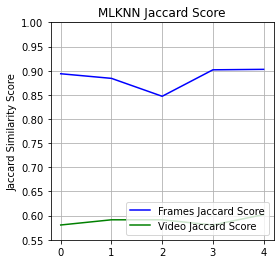

In [96]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.55, 1.0])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='lower right')
plt.show()

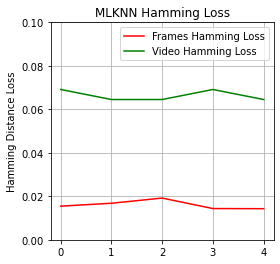

In [97]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, .1])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print(y_test[800:805])
print(metadata_test[800:805])

In [ ]:
print(len(y_test))
print(len(metadata_test))

In [ ]:
def clean(input: str):
    input = 'persian/' + input +".mp4"
    return input
X_df = pd.read_csv('../new_data/Persian/persian_dataset.csv', index_col=None)
X_df['filename'] = X_df['filename'].apply(clean)
X_df.to_csv('../new_data/Persian/persian_dataset.csv', index=False)